In [1]:
import bionetgen as pybng
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbrn
from scipy.optimize import minimize
from scipy.stats.distributions import uniform
from sklearn.linear_model import LinearRegression

/home/boltzmann/apps/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Advanced PyBNG usage for analysis

One of the core motivations behind PyBNG, besides easier installation, is to allow for analysis to be done via Python scripting or Jupyter notebooks. Jupyter notebooks in particular allow for easy sharing of analysis and results as well as being a great teaching tool. 



### Using an efficient simulator

While we don't have efficient simulators implemented yet, we have made it easy for users to use [libroadrunner](http://libroadrunner.org/) (I'll refer to it as libRR). LibRR is a high performance simulation engine that can read [SBML](http://model.caltech.edu/) files and has a [python API](http://sys-bio.github.io/roadrunner/docs-build/index.html). BioNetGen can export BNGL files as SBML and we can use the SBML to get us an efficient simulator that way. PyBNG allows you to automate this process using the `bngmodel` objects `setup_simulator` method. We will be using this method for the analyses shown in this notebook.

In [2]:
# Load model object
model = pybng.bngmodel("SIR.bngl")
# this gets you a libRoadRunner simulator
sim = model.setup_simulator().simulator
# this sets the observable names for the libroadrunner simulator
# Note, this will be automated in the future.
selections = ["time"] + [obs for obs in model.observables]
sim.timeCourseSelections = selections

BioNetGen version 2.6.0
Reading from file temp.bngl (level 0)
Read 6 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( temp )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  2.00e-02 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 2.00e-02 CPU s 2.00e-02 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 2.00e-02 CPU s 1.00e-02 CPU s/rxn
Wrote network in net format to ./temp.net.
CPU TIME: generate_network 0.02 s.
Wrote SBML to ./temp_sbml.xml.
CPU TIME: writeSBML 0.00 s.
Finished processing file temp.bngl.
CPU TIME: total 0.03 s.


Having access to both an efficient simulator and the model object allows us to inspect the model itself, run quick simulations and plot time series. This is very useful to understand how the model behaves.

In [3]:
# Taking a look at original parameter values
for pname in [i for i in model.parameters]:
    print("{} = {:.3g}".format(pname, getattr(sim, pname)))

N = 100
I0 = 1
R0 = 2.5
g = 0.33
b = 0.00825
_InitialConc1 = 99


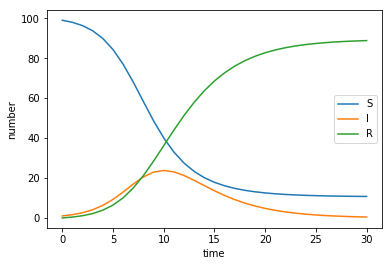

In [4]:
# Run a test simulation and plot
sim.reset()
res = sim.simulate(0, 30, 31)

# we can use the model object again for the observable names
for obs in [obs for obs in model.observables]:
    plt.plot(res['time'],res[obs], label=obs)
plt.xlabel('time')
plt.legend()
_ = plt.ylabel('number')

### Parameter scans

One of the simplest analyses we can do is to vary a parameters values and see how the model behavior changes. We show cased how to do parameter scans using PyBNG, with libRR simulator this is even more efficient than before.

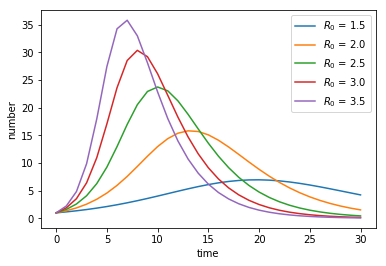

In [5]:
# simple parameter scan
for i in np.arange(1.5,4.0,0.5):
    # set parameter
    sim.R0 = np.float(i)
    # resets all concentrations, forces recalculation of parameters
    sim.reset()
    # simulate
    res = sim.simulate(0, 30, 31)
    # plot infected cell time series
    plt.plot(res['time'], res["I"], label=f"$R_{0}$ = {i}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

### Parameter estimation

Parameter estimation is generally involves minimizing a cost function. With our efficient simulator, we can easily write a cost function that can, for example, minimize the distance of the simulated data to reference data and minimize that function. [Scipy](https://docs.scipy.org/doc/scipy/index.html) provides good [minimization functions](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and is one of the most commonly used scientific libraries for python. 

Let's start with generating reference data with our model by simulating and adding noise.

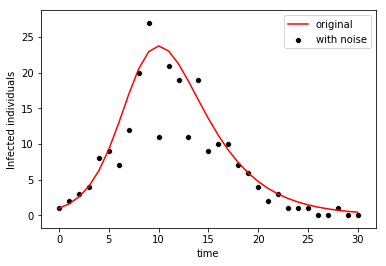

In [6]:
# Run a simulation for data generation
sim.resetAll()
res = sim.simulate(0, 30, 31)

# construct and save synthetic data set for I(t)
m_time = res['time']
m_I = res['I']
# convert infected data to integer and add noise
m_I += np.random.normal(loc=0,scale=0.3*m_I,size=len(m_I))
m_I = np.floor(m_I)
m_I[0] = sim.I0

# convert the data to pandas data frame for later use
d = {'time': m_time, 'I': m_I}
exp = pd.DataFrame(data=d)

# Plot original result and result of adding noise
sbrn.lineplot(x=res["time"], y=res["I"], color="red", label="original")
sbrn.scatterplot(x=exp.time, y=exp.I,color='black', label="with noise")
_ = plt.ylabel('Infected individuals')

Now we will need write a cost function that takes in a parameter array, simulates the model with the given set of parameters and calculate the difference (sum of squares of difference to be exact) between the results and our generated reference data.

In [7]:
def cost(params):
    """
    This cost function updates the parameters, 
    runs the model and takes the difference 
    between the model results and the generated data
    """
    sim.R0 = params[0]
    sim.g = params[1]
    sim.reset() # Updates the dependent parameters
    # simulate with the new parameters
    res_c = sim.simulate(0, 30, 31)
    # get the difference between the generated
    # data and the simulated values
    y_diff = exp['I'] - res_c['I']
    # return sum of squares
    return (sum(y_diff**2))

Let's do some plotting and checkout how the cost function works and what our initial parameter array result looks like. 

cost =  5069.631126430145


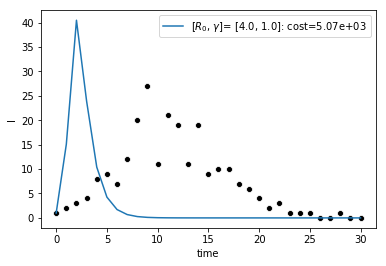

In [8]:
# Show starting cost function value and fit
p0=[4,1]
print("cost = ",cost(p0))
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = sbrn.lineplot(x=res['time'], y=res['I'], label=r'[$R_0$, $\gamma$]= [4.0, 1.0]: cost={:0.2e}'.format(cost(p0)))

### Nelder-mead minimization

[Nelder-mean minimization method](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#nelder-mead-simplex-algorithm-method-nelder-mead) is one of the methods [provided by `scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html#optimize-minimize-neldermead). Different minimization methods are good for different If types of problems, for a full list of methods provided by `scipy`, see [here](https://docs.scipy.org/doc/scipy/reference/optimize.html). Look [here](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#nelder-mead-simplex-algorithm-method-nelder-mead) for a more comprehensive tutorial on the methods provided by scipy. If you need more sophisticated methods you can try other libraries, like [PyBNF](https://github.com/lanl/PyBNF). 

Nelder-mead is a one of the simplest ways to find a minimum, let's see how Nelder-mead performs with our cost function.

In [9]:
# let's run the minimization
minimized = minimize(cost, x0=[10,0.1], method='nelder-mead',options={'maxiter':1000})
print(minimized)

 final_simplex: (array([[2.24833031, 0.37284493],
       [2.24839618, 0.37283727],
       [2.24836677, 0.37283164]]), array([251.68897364, 251.68897502, 251.68897994]))
           fun: 251.6889736414921
       message: 'Optimization terminated successfully.'
          nfev: 132
           nit: 69
        status: 0
       success: True
             x: array([2.24833031, 0.37284493])


Let's plot and see how the final value compares to our data

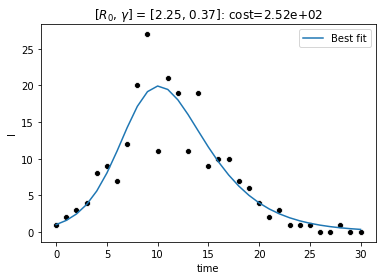

In [10]:
# Show final cost function value and fit
p_final= minimized.x
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = sbrn.lineplot(x=res['time'], y=res['I'], label="Best fit")
_ = plt.title(r'[$R_0$, $\gamma$] = [{:.2f}, {:.2f}]: cost={:0.2e}'.format(p_final[0], p_final[1], cost(p_final)))

### BFGS minimization

[BFGS](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#broyden-fletcher-goldfarb-shanno-algorithm-method-bfgs) is another minimization method [provided by `scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs). Unlike Nelder-mead, BFGS uses gradients (scipy estimates the gradients using first-differences) to find the minimum and is more suited for more complicated optimization problems.

Let's take a look at how BFGS performs with our cost function.

In [11]:
# run bfgs minimization this time
minimized_bfgs = minimize(cost, x0=[4,1], method='BFGS')
print(minimized_bfgs)

      fun: 251.68897214358853
 hess_inv: array([[8.51837253e-06, 1.72367735e-06],
       [1.72367735e-06, 3.48783800e-07]])
      jac: array([-0.00111198,  0.0062294 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 393
      nit: 20
     njev: 127
   status: 2
  success: False
        x: array([2.24835429, 0.37284437])


Let's plot and see how the final value compares to our data

cost =  251.68897214358853
x= [2.24835429 0.37284437]


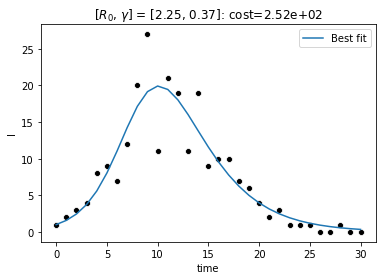

In [12]:
# Show final cost function value and fit
p_final= minimized_bfgs.x
print("cost = ", cost(p_final))
print('x=',p_final)
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(exp.time, exp.I,color='black')
_ = sbrn.lineplot(res['time'], res['I'], label="Best fit")
_ = plt.title(r'[$R_0$, $\gamma$] = [{:.2f}, {:.2f}]: cost={:0.2e}'.format(p_final[0], p_final[1], cost(p_final)))

# Simple sensitivity analysis using linear regression 

Sometimes we have experimental data to match to but sometimes we just want to know how a set of model parameters impact a given observable. Doing parameter scans is a good way to get a sense of how they impact an observable, but that's not enough when we are working with a set of parameters that might be correlated in various ways. 

Let's start by doing a couple parameter scans for R<sub>0</sub> and g and how those change and see how many recovered cells we are left with at the end of the simulation.

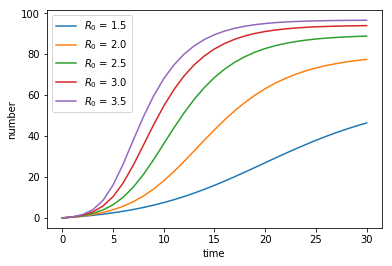

In [13]:
# reset all parameters from previous runs
sim.resetAll()
# simple parameter scan
for i in np.arange(1.5,4.0,0.5):
    sim.R0 = np.float(i)
    sim.reset()
    res = sim.simulate(0,30,31)
    plt.plot(res['time'], res["R"], label=f"$R_{0}$ = {i}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

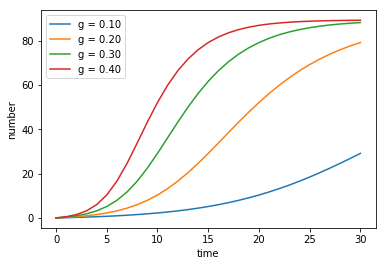

In [14]:
# reset all parameters from previous scan
sim.resetAll()
# simple parameter scan
for i in np.arange(0.1,0.5,0.1):
    sim.g = np.float(i)
    sim.reset()
    res = sim.simulate(0,30,31)
    plt.plot(res['time'], res["R"], label=f"g = {i:.02f}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

Now let's say we wanted to see exactly how R<sub>0</sub> and g affects the final recovered cell count. This information will not only give us how these parameters affect the observable value but also allows us to adjust our parameters so that the observable matches a particular value, say a value you know from experimental results. 

This analysis will require random samples to simulate for two parameters. A standard way to get random numbers for multiple dimensions is to use [latin-hypercube sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling). An efficient implementation can be found in a python library called [PyDOE](https://pythonhosted.org/pyDOE/). Execute the next cell if you don't have it installed.

In [15]:
# import sys
# !{sys.executable} -m pip install pyDOE
import pyDOE

Now that we have the library, let's use it for generating samples for our parameters. We will sample an order of magnitude around our starting values. We will also be doing our sampling in log space, this tends to work a lot better for most applications.

In [16]:
sim.resetAll()
# selecting parameters to vary for sensitivity analysis
to_scan = ["R0", "g"]
n_dim = len(to_scan)
# set number of samples
n_samples = int(1e4)
# Getting latin hypercube samples using pyDOE library
lhs_samples = pyDOE.lhs(n_dim, samples=n_samples)
# Get initial parameter values
param_values = [getattr(sim, rate_name) for rate_name in to_scan]
param_values = np.log10(param_values)
# selecting the scale, original value is 1 for an order of magnitude
scale = 1
lhs_samples = uniform(loc=-scale, scale=scale*2.0).ppf(lhs_samples)
# move the center of the distribution to the inital parameter values
for i in range(n_dim):
    lhs_samples[:,i] += param_values[i]
# let's make sure we got the scale right
for i in range(n_dim):
    orig_value = np.float(model.parameters[to_scan[i]].value)
    orig_value = np.log10(orig_value)
    print(f"parameter: {to_scan[i]}, original value: {np.power(10,orig_value)}")
    print(f"sample min: {np.power(10,lhs_samples[:,i].min())}, sample max: {np.power(10,lhs_samples[:,i].max())}")

parameter: R0, original value: 2.5
sample min: 0.2500358059966873, sample max: 24.993555530733218
parameter: g, original value: 0.33
sample min: 0.03300773891404782, sample max: 3.298929340086632


Now we need to write a simple simulate command (kind of like our cost function) and a command to get our observable, the final recovered cell value.

In [17]:
def simulate_param(simulator, parameters):
    """
    This is to simulate a given set of parameters using the 
    given simulator and return the resulting array. Parameters
    are used assuming they are in log10 space. 
    """
    for pind, pname in enumerate(to_scan):
        simulator.setGlobalParameterByName(pname, np.power(10, parameters[pind]))
    simulator.reset()
    res_c = sim.simulate(0, 30, 31)
    return res_c

def get_obs(result):
    """
    This function takes in the result array and returns
    the observable of interest. In this case it's the final
    recovered cell count. 
    """
    return result["R"][-1]

Now we are ready to start our run. We will loop over all samples we generated and add them to lists. Not every parameter array is valid, some models simply won't converge for certain set of values. We will just skip those arrays in case our simulation fails.

In [18]:
results = []
observables = []
samples = []

for sample in lhs_samples:
    # not all parameter values are possible
    # so we need to account for potential failures here
    try:
        res = simulate_param(sim, sample)
    except RuntimeError:
        continue
    samples.append(sample)
    results.append(res)
    observables.append(get_obs(res))

results = np.array(results)
observables = np.array(observables)
samples = np.array(samples)
print(f"{len(results)} samples successfuly simulated")

10000 samples successfuly simulated


Next we will do a very simple way to estimate how the parameter values affect the observables. We will use another very commonly used scientific python library called [scikit-learn](https://scikit-learn.org/stable/) which is a machine learning library. We will use the [linear models](https://scikit-learn.org/stable/modules/linear_model.html) to do [ordinary least square fitting](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares). 

fit score 0.8127674598059931
R0 coefficient: 1.1683954321372079, g coefficient: 0.3330242279874193


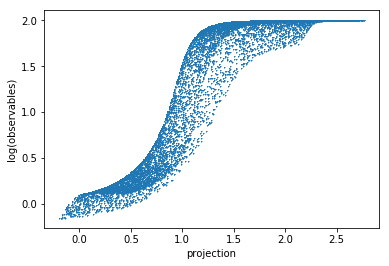

In [19]:
# make sure to remove any negative values
inds_to_use = observables > 0
observables = observables[inds_to_use]
obs = np.log10(observables)
samples = samples[inds_to_use]

# Do the linear regression
reg = LinearRegression().fit(samples,obs)
proj = reg.predict(samples)
score = reg.score(samples, obs)
# Get some information on our fit
print(f"fit score {score}")
print(f"R0 coefficient: {reg.coef_[0]}, g coefficient: {reg.coef_[1]}")

# Plot the observable values versus our predictions
plt.plot(proj, obs, lw=0, marker="+", markersize=1)
plt.ylabel("log(observables)")
_ = plt.xlabel("projection")

Now let's see if we can use the resulting coefficient vector to adjust our observable values. We will simply take our coefficient vector multiplied by a scaling factor and add it to the initial parameter vector and see how the recovered cell counts change over a set of scaling factors.

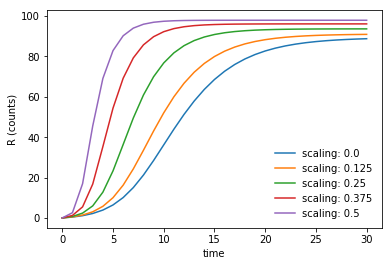

In [20]:
# we want the original parameter values, so let's reset
sim.resetAll()

# we'll change our parameters using our linear regression
# coefficients multiplied by a scaling factor
scaling_obs = []
for lam in np.linspace(0, 0.5, num=5):
    for iparam, pname in enumerate(to_scan):
        # get original value
        cval = sim.getGlobalParameterByName(pname)
        # adjust by scaling factor * coefficient
        sim.setGlobalParameterByName(pname, cval+(lam*reg.coef_[iparam]))
    # reset concentrations, force parameter recalculation
    sim.reset()
    # simulate, get observables, plot
    res = sim.simulate(0,30,31)
    scaling_obs.append(get_obs(res))
    plt.plot(res["time"], res["R"], label=f"scaling: {lam}")
plt.xlabel("time")
plt.ylabel("R (counts)")
_ = plt.legend(frameon=False)

It looks like we managed to find a good coefficient vector to adjust the observable! Let's see if it's actually linear by plotting the scaling factors and the actual observable value, the final recovered cell count. 

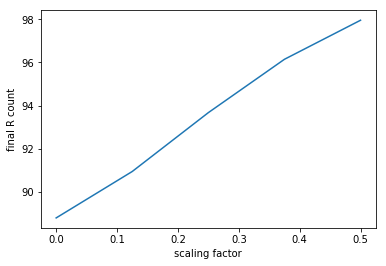

In [21]:
# let's see if the scaling vs observable is actually linear 
plt.plot(np.linspace(0, 0.5, num=5), scaling_obs)
plt.xlabel("scaling factor")
_ = plt.ylabel("final R count")